# CNCITY - cassandraConnect


# Importing python packages 

In [1]:
import os
import sys

# Data Analysis
import pandas as pd

# Cassandra
from connection_manager import cassandraConnect
from cassandra.query import dict_factory

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import tqdm as tqdm
from tabulate import tabulate


# Importing the dataset - saved it to a variable called 'df'

In [3]:
PORT = 9042
KEYSPACE = "cncity_server"
TABLE = "all_data"

# Source DB
CONTACT_POINTS = ["39.118.41.24"]
USERNAME = "cnscada"
PW = "cnscada123!@#"

cc = cassandraConnect(CONTACT_POINTS, USERNAME, PW)
cc.session.row_factory = dict_factory

Connected to Cassandra Successfully: ['39.118.41.24'] 9042


In [4]:
use_machine_code = 1
use_day = 20240603
# save_path = os.path.join('.', 'data', f'Machine{use_machine_code}_{use_day}.csv')

###################################

query = """
    SELECT *
    FROM {keyspace_name}.{table_name}
    WHERE machine_code = {query_machine_code}
    AND day = {query_day}
""".format(
    keyspace_name = KEYSPACE,
    table_name = TABLE,
    query_machine_code = use_machine_code,
    query_day = use_day
)

query_result = cc.session.execute(query)
###################################

# Pandas DataFrame으로 전환
df_1 = pd.DataFrame(list(query_result)).sort_values(by='time')
# df.to_csv(save_path, index=False)

print(df_1.shape)
df_1.head()

(86261, 22)


,machine_code,day,time,door_open,electricity_1,electricity_2,gas_leak,is_maintenance,machine_type,network_status,...,power_on,pressure_1,pressure_2,ssv1,ssv2,status_electricity_1,status_electricity_2,status_pressure_1,status_pressure_2,weektime
86260,1,20240603,0,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.130,0,0,0,0,0,0,0
86259,1,20240603,1,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.130,0,0,0,0,0,0,0
86258,1,20240603,2,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.130,0,0,0,0,0,0,0
86257,1,20240603,3,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.144,0,0,0,0,0,0,0
86256,1,20240603,4,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.144,0,0,0,0,0,0,0


In [5]:
def query(day, machine_code):
    use_machine_code = machine_code
    use_day = day
    # save_path = os.path.join('.', 'data', f'Machine{use_machine_code}_{use_day}.csv')

    ###################################

    query = """
        SELECT *
        FROM {keyspace_name}.{table_name}
        WHERE machine_code = {query_machine_code}
        AND day = {query_day}
    """.format(
        keyspace_name = KEYSPACE,
        table_name = TABLE,
        query_machine_code = use_machine_code,
        query_day = use_day
    )

    query_result = cc.session.execute(query)
    ###################################

    # Pandas DataFrame으로 전환
    df_1 = pd.DataFrame(list(query_result)).sort_values(by='time')
    # df.to_csv(save_path, index=False)

    # print(df_1.shape)
    # print(df_1.head())
    return df_1


In [6]:
def process_dataframe(df, aggregation):
    # Extract hour from 'Time' column (assuming 'Time' is in seconds since midnight)
    df['Hour'] = df['time'].dropna() // 10000
    
    # Group by 'Hour' and aggregate the data
    if aggregation == 'mean':
        result_df = df.groupby('Hour').mean().reset_index()
    elif aggregation == 'median':
        result_df = df.groupby('Hour').median().reset_index()
    elif aggregation == 'mode':
        # Mode can return multiple values, we need the first one
        result_df = df.groupby('Hour').agg(lambda x: x.mode().iloc[0]).reset_index()
    elif aggregation == 'max': 
        result_df = df.groupby('Hour').max().reset_index()
    else:
        raise ValueError("Aggregation method not supported. Use 'mean', 'median', or 'mode'.")
    
    # Drop the 'Time' column as it's not needed in the result
    result_df = result_df.drop(columns=['time'])
    
    return result_df

# result_df = process_dataframe(df,'max')

# Visualization - plotted each variable

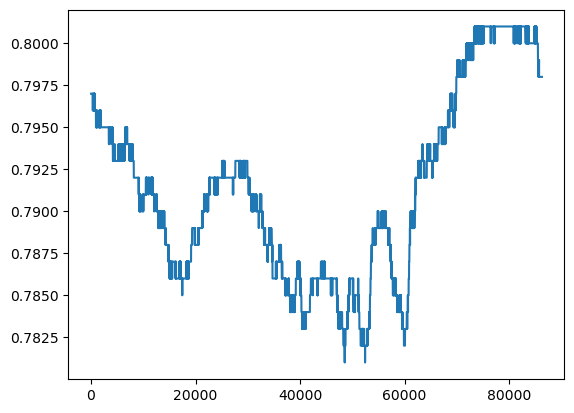

In [7]:
plt.plot(df_1['pressure_1'])

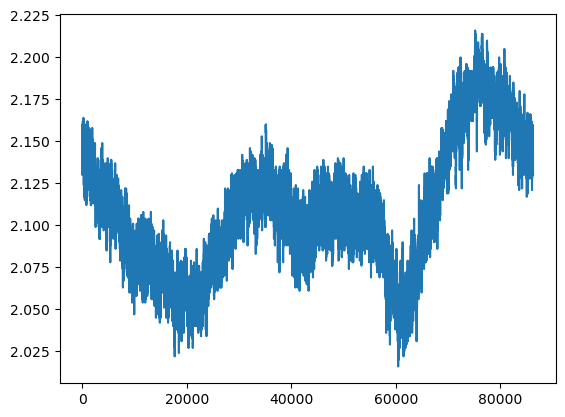

In [8]:
plt.plot(df_1['pressure_2'])

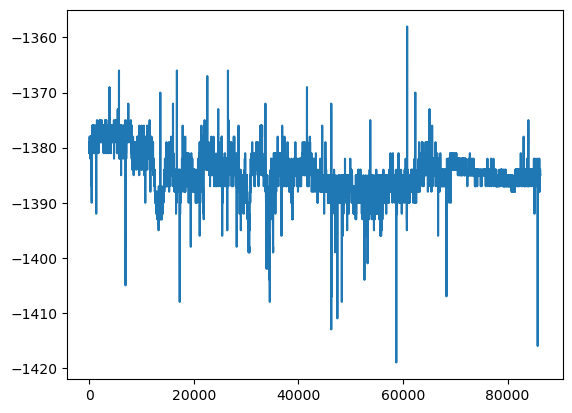

In [9]:
plt.plot(df_1['electricity_1'])

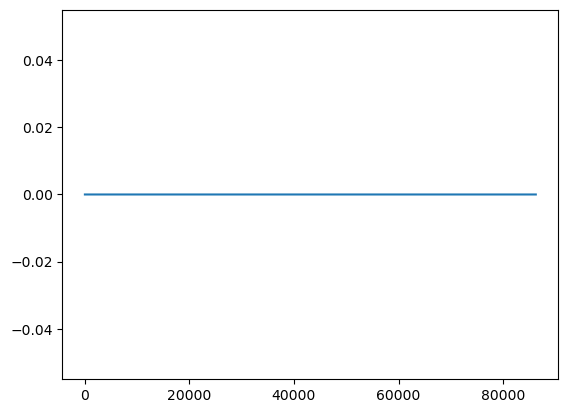

In [10]:
plt.plot(df_1['electricity_2'])

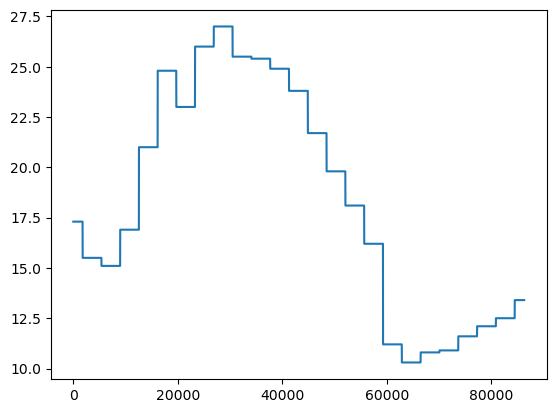

In [11]:
plt.plot(df_1['outside_temperature'])

# Linear Regression Plots 

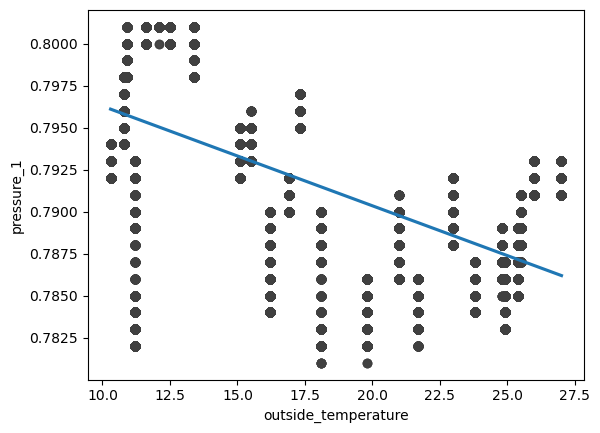

In [12]:
# linear regression with outside_temperature and pressure_1
ax = sns.regplot(x='outside_temperature', y= 'pressure_1', data=df_1, ci=None, scatter_kws=dict(color='0.25'))

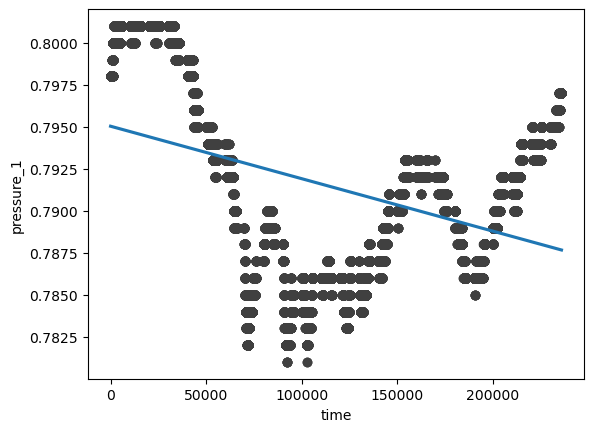

In [13]:
# linear regression with time and pressure_1
ax = sns.regplot(x='time',y='pressure_1',data=df_1,ci = None, scatter_kws = dict(color = '0.25'))

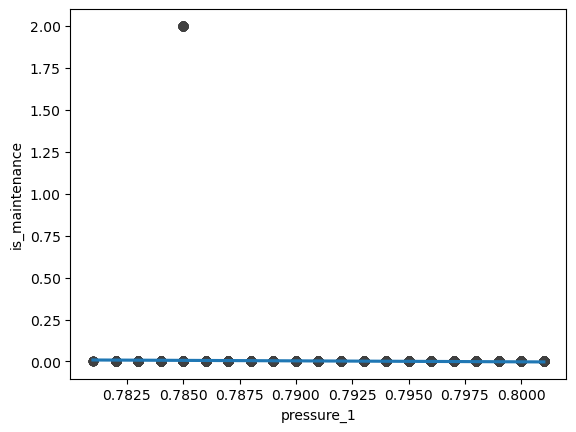

In [14]:
# linear regression with pressure_1 and is_maintenance (doesn't provide us with that much insight)
ax = sns.regplot(x = 'pressure_1', y='is_maintenance',data= df_1,ci = None, scatter_kws = dict(color = '0.25'))

# Linear regression (using the python package) 
1. pressure_1 and outside_temperature

In [15]:
model_gas_and_temp = LinearRegression()

In [16]:
# transforms the columns into numpy arrays
pressure_1_array = np.array(df_1['pressure_1']).reshape(-1,1)
temperature_array= np.array(df_1['outside_temperature']).reshape(-1,1)

In [17]:
# splits the arrays into train and test sets
temp_train, temp_test, pressure_train, pressure_test = train_test_split(temperature_array, pressure_1_array, random_state=104, test_size=0.25, shuffle=True )

In [18]:
# trains the model
model_gas_and_temp.fit(temp_train, pressure_train)

LinearRegression()

In [19]:
# uses the model to predict 'pressure_1' values
predicted_pressure = model_gas_and_temp.predict(temp_test)

In [20]:
# gives us the slope and intercept of the linear regression model
a = float(model_gas_and_temp.coef_)
b = float(model_gas_and_temp.intercept_)
print(f'y = {a:.7f}x + {b:3f}')

y = -0.0005971x + 0.802281


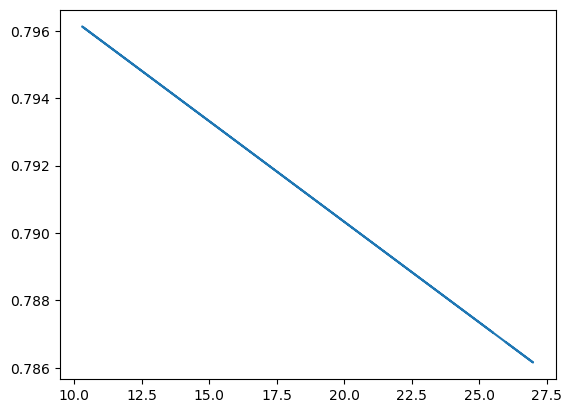

In [21]:
plt.plot(temp_test,predicted_pressure)
plt.xlabel = 'temperature'
plt.ylabel = 'pressure_1'

# Linear regression - now with electricity_1 and pressure_1

In [22]:
model_electricity_pressure = LinearRegression()

In [23]:
# takes the columns and turns them into numpy arrays
electricity_1_array = np.array(df_1['electricity_1']).reshape(-1,1)
pressure_2_array = np.array(df_1['pressure_1']).reshape(-1,1)

In [24]:
# splits the arrays into train and test sets
electricity_train, electricity_test, pressure_train, pressure_test = train_test_split(electricity_1_array, pressure_2_array,random_state=104, test_size=0.25, shuffle=True)

In [25]:
# trains the model
model_electricity_pressure.fit(electricity_train, pressure_train)

LinearRegression()

In [26]:
# uses the model to predict pressure_1
y_pred_pressure = model_electricity_pressure.predict(electricity_test)

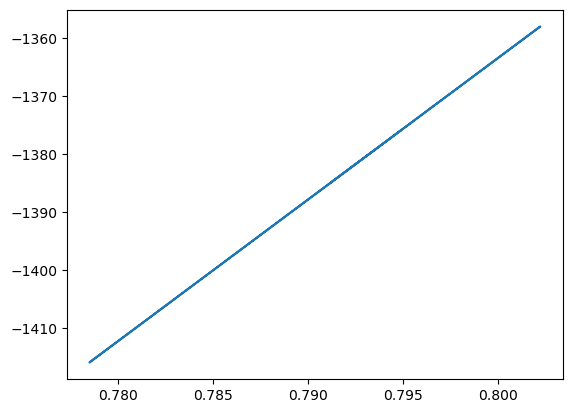

In [27]:
plt.plot(y_pred_pressure, electricity_test)

# Logistic Regression with pressure_1 and is_maintenance

In [28]:
model_log = LogisticRegression()

In [29]:
# creates numpy arrays using the columns in our dataframe
maintenance_array = np.array(df_1['is_maintenance']).reshape(-1,1)
time_array = np.array(df_1['time']).reshape(-1,1)
pressure_array = np.array(df_1['pressure_1']).reshape(-1,1)

In [30]:
# splits them into train and test sets
X_train, X_test, y_train, y_test = train_test_split(pressure_array,maintenance_array,random_state=104,test_size=0.25,shuffle=True) 

In [31]:
# trains the model
model_log.fit(X_train, y_train)

/Users/annikaseo-yeonkim/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [32]:
# uses that to predict is_maintenance
y_pred_log = model_log.predict(X_test)

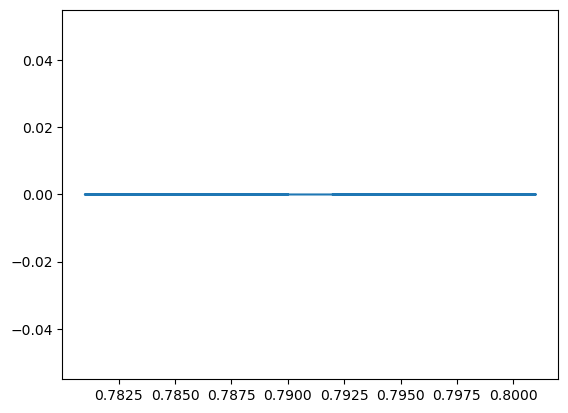

In [33]:
plt.plot(X_test, y_pred_log)

# Autoregression using lag plot

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

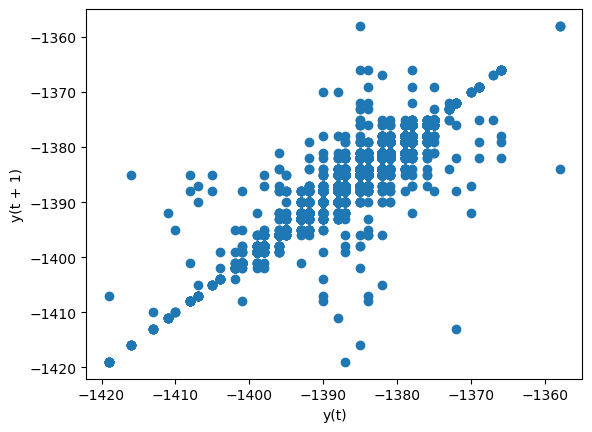

In [34]:
pd.plotting.lag_plot(df_1['electricity_1'],lag=1)

# Autocorrelation plots 

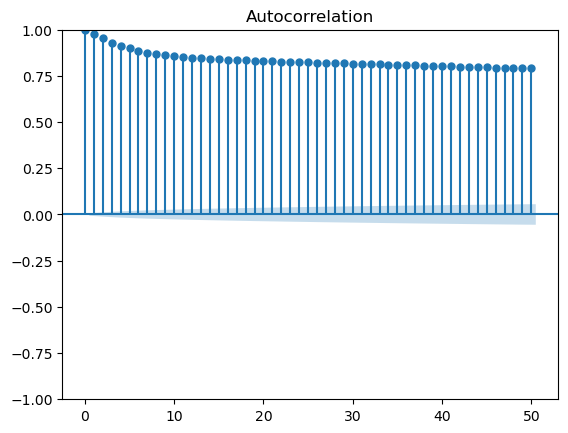

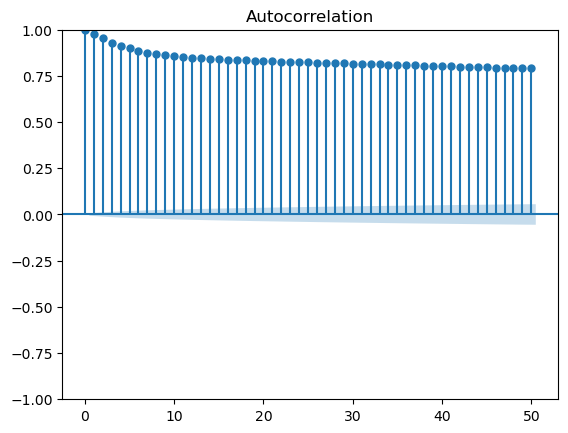

In [35]:
plot_acf(df_1['electricity_1'])

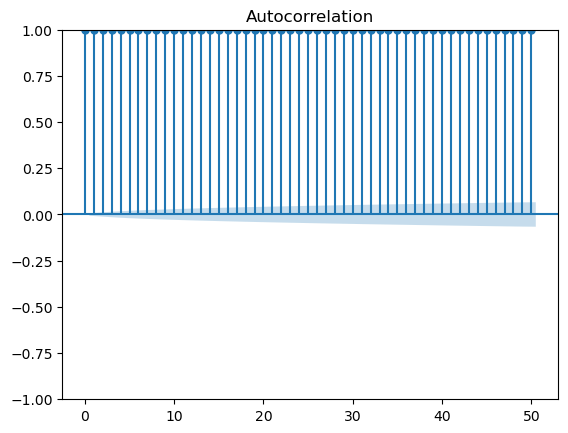

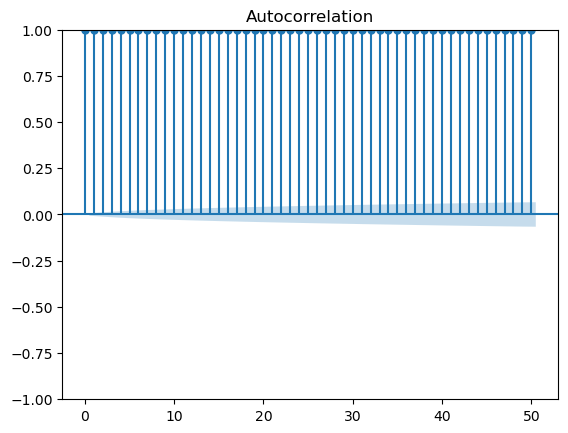

In [36]:
# log transformation - does nothing
log_pressure = np.log(df_1['pressure_1'])
plot_acf(log_pressure)

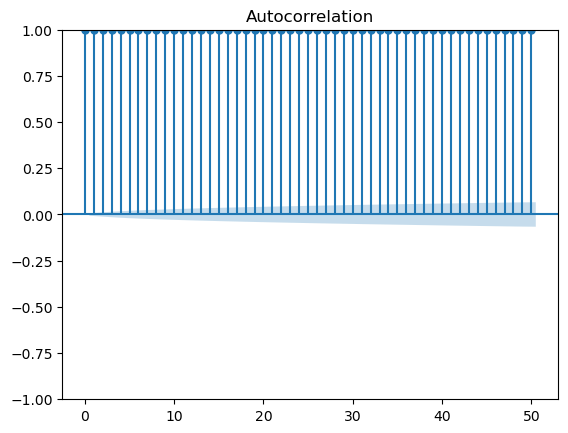

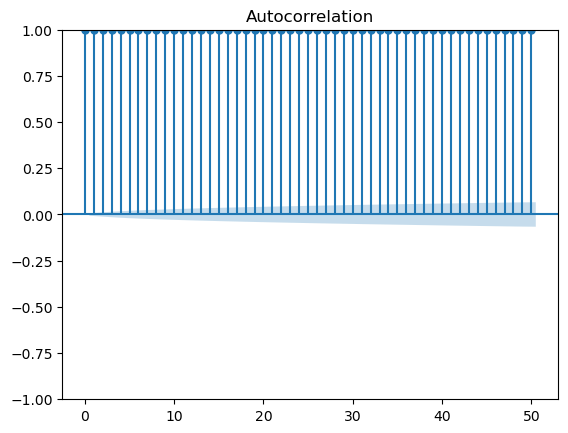

In [37]:
plot_acf(df_1['pressure_1'])

# Rolling Average Plots

In [39]:
rolling_average = df.electricity_1.rolling(1000).mean() # window = 1000

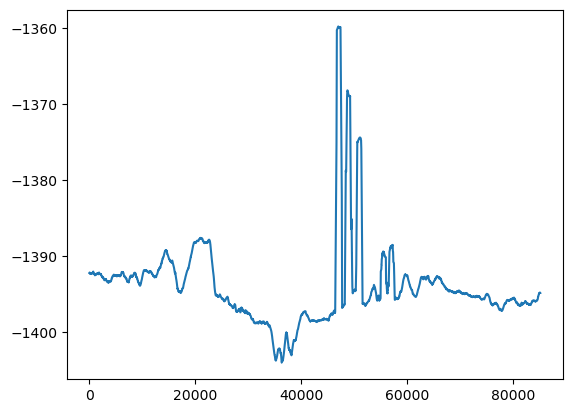

In [40]:
plt.plot(rolling_average)

In [173]:
rolling_average_2 = df_1.electricity_1.rolling(10000).mean() # window = 10000

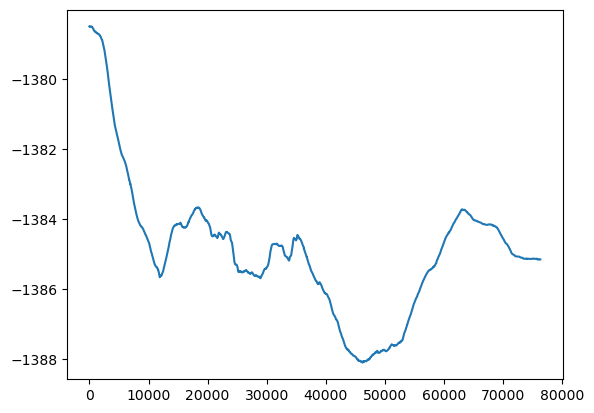

In [174]:
plt.plot(rolling_average_2)

<b> #2. pressure_1 </b>

In [175]:
rolling_average_pressure = df_1.pressure_1.rolling(1000).mean()

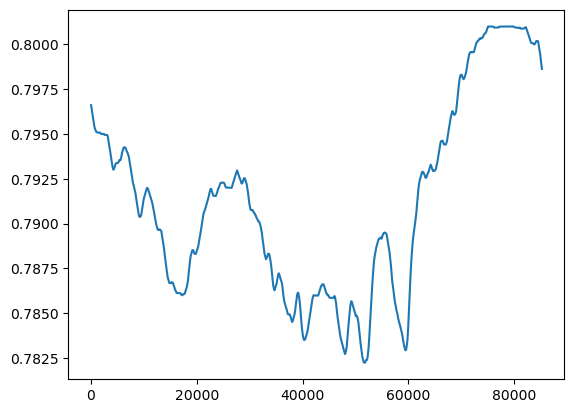

In [176]:
plt.plot(rolling_average_pressure)

In [177]:
rolling_average_pressure_1 = df_1.pressure_1.rolling(10000).mean()

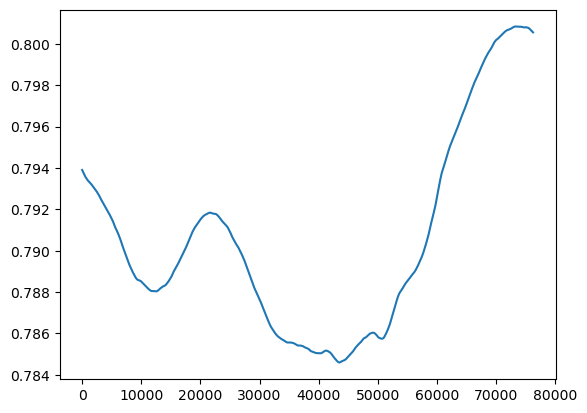

In [178]:
plt.plot(rolling_average_pressure_1)

In [179]:
rolling_average_electricity_2 = df_1.electricity_2.rolling(1000).mean()

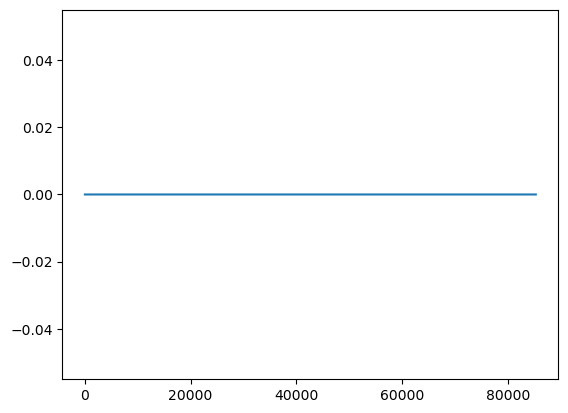

In [180]:
plt.plot(rolling_average_electricity_2)

# 대표값 찾기 

# consolidating the dataset 

In [181]:
df_1.groupby('time').head()

,machine_code,day,time,door_open,electricity_1,electricity_2,gas_leak,is_maintenance,machine_type,network_status,...,power_on,pressure_1,pressure_2,ssv1,ssv2,status_electricity_1,status_electricity_2,status_pressure_1,status_pressure_2,weektime
86260,1,20240603,0,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.130,0,0,0,0,0,0,0
86259,1,20240603,1,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.130,0,0,0,0,0,0,0
86258,1,20240603,2,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.130,0,0,0,0,0,0,0
86257,1,20240603,3,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.144,0,0,0,0,0,0,0
86256,1,20240603,4,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.144,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1,20240603,235955,0,-1379.0,0.0,0,0,1,0,...,0,0.797,2.137,0,0,0,0,0,0,0
3,1,20240603,235956,0,-1379.0,0.0,0,0,1,0,...,0,0.797,2.137,0,0,0,0,0,0,0
2,1,20240603,235957,0,-1379.0,0.0,0,0,1,0,...,0,0.797,2.137,0,0,0,0,0,0,0
1,1,20240603,235958,0,-1379.0,0.0,0,0,1,0,...,0,0.797,2.137,0,0,0,0,0,0,0


In [187]:
consolidated_df = pd.DataFrame()
electricity_average = df_1['electricity_1'].dropna().rolling(59).mean()
consolidated_df['electricity_1'] = electricity_average

In [183]:
consolidated_df['electricity_1'].isnull().sum()

58

In [184]:
df_clean = df_1.copy()
df_clean.head()

,machine_code,day,time,door_open,electricity_1,electricity_2,gas_leak,is_maintenance,machine_type,network_status,...,power_on,pressure_1,pressure_2,ssv1,ssv2,status_electricity_1,status_electricity_2,status_pressure_1,status_pressure_2,weektime
86260,1,20240603,0,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.130,0,0,0,0,0,0,0
86259,1,20240603,1,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.130,0,0,0,0,0,0,0
86258,1,20240603,2,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.130,0,0,0,0,0,0,0
86257,1,20240603,3,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.144,0,0,0,0,0,0,0
86256,1,20240603,4,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.144,0,0,0,0,0,0,0


# process_dataframe and query

In [38]:
def query(day, machine_code):
    use_machine_code = machine_code
    use_day = day
    # save_path = os.path.join('.', 'data', f'Machine{use_machine_code}_{use_day}.csv')

    ###################################

    query = """
        SELECT *
        FROM {keyspace_name}.{table_name}
        WHERE machine_code = {query_machine_code}
        AND day = {query_day}
    """.format(
        keyspace_name = KEYSPACE,
        table_name = TABLE,
        query_machine_code = use_machine_code,
        query_day = use_day
    )

    query_result = cc.session.execute(query)
    ###################################

    # Pandas DataFrame으로 전환
    df_1 = pd.DataFrame(list(query_result)).sort_values(by = 'time')
    # df.to_csv(save_path, index=False)

    # print(df_1.shape)
    # print(df_1.head())
    return df_1



In [216]:
processed_dataframe_list = []
day_to_query = [20240603,20240604,20240605,20240606,20240607,20240608,20240609]
# df = query(20240603,1)
# df.columns
for day in day_to_query:
    df = query(day,1)
    new_df = process_dataframe(df,'max')
    processed_dataframe_list.append(new_df)
del df
del new_df
final_df = pd.concat(processed_dataframe_list, axis = 1)

# final_df.head()

# final_df.T.shape

# final_df['Hour']

In [39]:
processed_dataframe_list_2 = []
start_date = 20240401

while start_date < 20240430:
    df = query(start_date,1)
    new_df = process_dataframe(df,'max')
    processed_dataframe_list_2.append(new_df)
    start_date+=1
del df
del new_df
final_df_2 = pd.concat(processed_dataframe_list_2, axis = 0)

final_df_2.head()

final_df_2['day']



0     20240401
1     20240401
2     20240401
3     20240401
4     20240401
        ...   
19    20240429
20    20240429
21    20240429
22    20240429
23    20240429
Name: day, Length: 696, dtype: int64

In [40]:
final_df_2['day']

0     20240401
1     20240401
2     20240401
3     20240401
4     20240401
        ...   
19    20240429
20    20240429
21    20240429
22    20240429
23    20240429
Name: day, Length: 696, dtype: int64

In [41]:
processed_dataframe_list_3 = []
start_date = 20240201

while start_date < 20240228:
    df = query(start_date, 1)
    new_df = process_dataframe(df, 'max')
    processed_dataframe_list_3.append(new_df)
    start_date+=1

del df
del new_df

final_df_3 = pd.concat(processed_dataframe_list_3, axis =0)

final_df_3.head()

,Hour,machine_code,day,door_open,electricity_1,electricity_2,gas_leak,is_maintenance,machine_type,network_status,...,power_on,pressure_1,pressure_2,ssv1,ssv2,status_electricity_1,status_electricity_2,status_pressure_1,status_pressure_2,weektime
0,0,1,20240201,0,-1408.0,0.0,0,0,1,0,...,0,0.781,2.167,0,0,0,0,0,0,0
1,1,1,20240201,0,-1404.0,0.0,0,0,1,0,...,0,0.784,2.173,0,0,0,0,0,0,0
2,2,1,20240201,0,-1408.0,0.0,0,0,1,0,...,0,0.784,2.174,0,0,0,0,0,0,0
3,3,1,20240201,0,-1407.0,0.0,0,0,1,0,...,0,0.781,2.169,0,0,0,0,0,0,0
4,4,1,20240201,0,-1401.0,0.0,0,0,1,0,...,0,0.773,2.155,0,0,0,0,0,0,0


In [47]:
final_df_22 = final_df_2.copy()
final_df_22['day'] = pd.to_datetime(final_df_22['day'])
final_df_22['day']

0    1970-01-01 00:00:00.020240401
1    1970-01-01 00:00:00.020240401
2    1970-01-01 00:00:00.020240401
3    1970-01-01 00:00:00.020240401
4    1970-01-01 00:00:00.020240401
                  ...             
19   1970-01-01 00:00:00.020240429
20   1970-01-01 00:00:00.020240429
21   1970-01-01 00:00:00.020240429
22   1970-01-01 00:00:00.020240429
23   1970-01-01 00:00:00.020240429
Name: day, Length: 696, dtype: datetime64[ns]

In [64]:
final_df_22 = final_df_2.copy()
day_list = list(final_df_22['day'])
day = day_list[0]

In [73]:
import datetime
from datetime import datetime, timedelta
# day_string = str(day_list[0])
# day_datetime = datetime.strptime(day_string, '%Y%m%d')
# day_datetime
new_date_list = []
for item in day_list:
    day_string = str(item)
    day_datetime = datetime.strptime(day_string, '%Y%m%d')
    new_date_list.append(day_datetime)

final_df_22['day'] = new_date_list

final_df_22['day']

0    2024-04-01
1    2024-04-01
2    2024-04-01
3    2024-04-01
4    2024-04-01
        ...    
19   2024-04-29
20   2024-04-29
21   2024-04-29
22   2024-04-29
23   2024-04-29
Name: day, Length: 696, dtype: datetime64[ns]

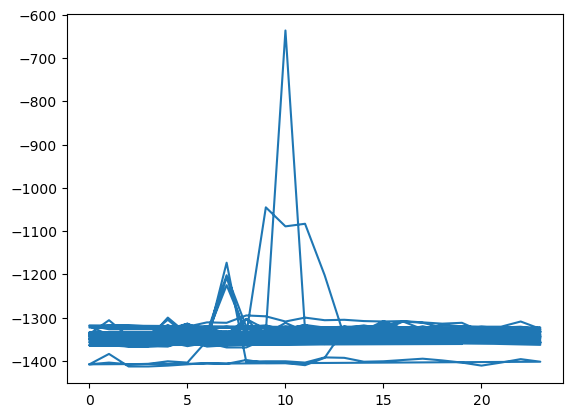

In [42]:
plt.plot(final_df_3['electricity_1'])

In [262]:
day_list = []
start_date = 20240401
while start_date < 20240430:
    day_list.append(start_date)
    start_date+=1


In [290]:
day_list_2 = []
start_date_2 =20240201
while start_date_2 < 20240228:
    day_list_2.append(start_date_2)
    start_date_2 +=1 


In [ ]:
final_df_2.describe()

,Hour,machine_code,day,door_open,electricity_1,electricity_2,gas_leak,is_maintenance,machine_type,network_status,...,power_on,pressure_1,pressure_2,ssv1,ssv2,status_electricity_1,status_electricity_2,status_pressure_1,status_pressure_2,weektime
count,24.000000,24.0,24.0,24.000000,24.000000,24.0,24.000000,24.000000,24.0,24.0,...,24.0,24.000000,24.000000,24.0,24.0,24.0,24.0,24.0,24.0,24.0
mean,11.500000,1.0,20240401.0,0.041667,-1236.625000,0.0,0.041667,0.083333,1.0,0.0,...,0.0,0.793250,2.144458,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,7.071068,0.0,0.0,0.204124,10.068515,0.0,0.204124,0.408248,0.0,0.0,...,0.0,0.003802,0.034153,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,1.0,20240401.0,0.000000,-1248.000000,0.0,0.000000,0.000000,1.0,0.0,...,0.0,0.786000,2.079000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,5.750000,1.0,20240401.0,0.000000,-1245.000000,0.0,0.000000,0.000000,1.0,0.0,...,0.0,0.790000,2.123250,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,11.500000,1.0,20240401.0,0.000000,-1240.000000,0.0,0.000000,0.000000,1.0,0.0,...,0.0,0.792500,2.147000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,17.250000,1.0,20240401.0,0.000000,-1230.750000,0.0,0.000000,0.000000,1.0,0.0,...,0.0,0.796000,2.160250,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,23.000000,1.0,20240401.0,1.000000,-1213.000000,0.0,1.000000,2.000000,1.0,0.0,...,0.0,0.799000,2.201000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
import matplotlib.dates as mdates

In [78]:
def plot_kmeans_results(variable_1,variable_2):
    rotation_angle = 45
    date_form = mdates.DateFormatter('%Y-%m-%d')
    # for key in keys:
    ax = plt.gca()
    ax.xaxis.set_major_formatter(date_form)
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right")
    # RMS 시계열
    plt.plot(variable_1, variable_2, label='April')
    # 그래프 제목과 레이블 설정
    # plt.title(f'K-means Labels and RMS Values for key {key}, operating: {len(indices)},  non-operating: {len(labels_kmeans[start_index:end_index]) - len(indices)}', fontsize=16)
    # plt.xlabel('Day', fontsize=14)
    # plt.ylabel('Variable', fontsize=14)
    # 범례 추가
    plt.legend()
    # 그리드 추가
    plt.grid(True)
    # 그래프 표시
    plt.show()

In [79]:
final_df_2

,Hour,machine_code,day,door_open,electricity_1,electricity_2,gas_leak,is_maintenance,machine_type,network_status,...,power_on,pressure_1,pressure_2,ssv1,ssv2,status_electricity_1,status_electricity_2,status_pressure_1,status_pressure_2,weektime
0,0,1,20240401,0,-1245.0,0.0,0,0,1,0,...,0,0.793,2.151,0,0,0,0,0,0,0
1,1,1,20240401,0,-1245.0,0.0,0,0,1,0,...,0,0.794,2.164,0,0,0,0,0,0,0
2,2,1,20240401,0,-1239.0,0.0,0,0,1,0,...,0,0.793,2.173,0,0,0,0,0,0,0
3,3,1,20240401,0,-1236.0,0.0,0,0,1,0,...,0,0.792,2.153,0,0,0,0,0,0,0
4,4,1,20240401,0,-1231.0,0.0,0,0,1,0,...,0,0.787,2.142,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,19,1,20240429,0,-1385.0,0.0,0,0,1,0,...,0,0.786,2.092,0,0,0,0,0,0,0
20,20,1,20240429,0,-1385.0,0.0,0,0,1,0,...,0,0.790,2.113,0,0,0,0,0,0,0
21,21,1,20240429,0,-1387.0,0.0,0,0,1,0,...,0,0.792,2.121,0,0,0,0,0,0,0
22,22,1,20240429,0,-1385.0,0.0,0,0,1,0,...,0,0.795,2.135,0,0,0,0,0,0,0


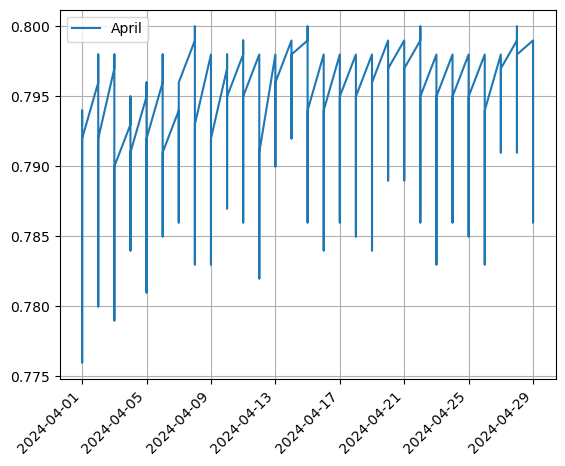

In [83]:
plot_kmeans_results(final_df_22['day'], final_df_22['pressure_1'])

In [322]:
# final_df_2['pressure_2'].head(25)
original_index =  [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
print(final_df_2['pressure_2'].index.tolist())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,

# pressure_1: visualization, analysis, etc

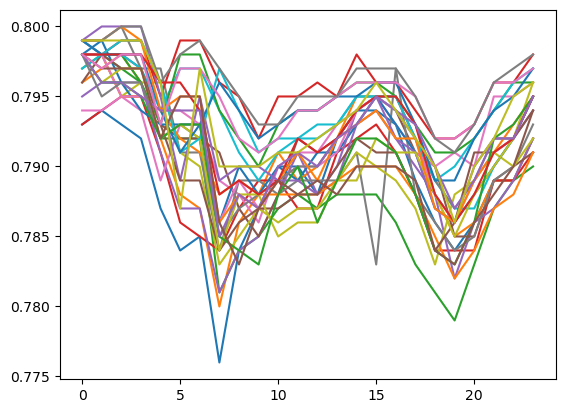

In [261]:
# visualization
plt.plot(final_df_2['pressure_1'])

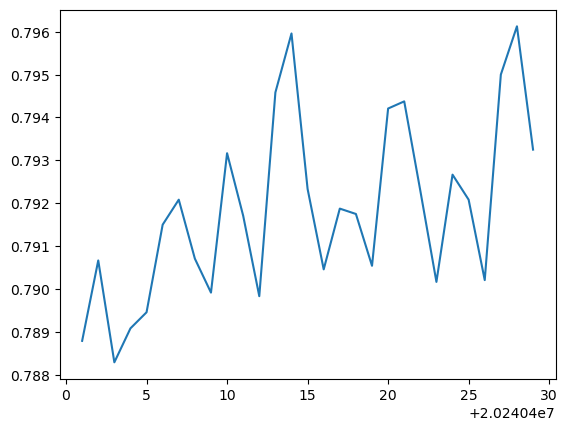

In [264]:
plt.plot(day_list, final_df_2['pressure_1'].mean())

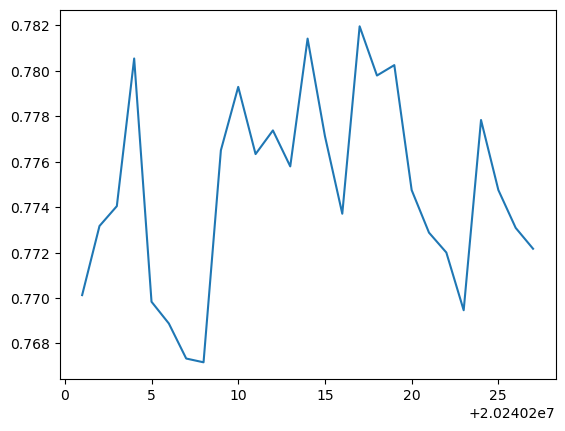

In [291]:
plt.plot(day_list_2, final_df_3['pressure_1'].mean())

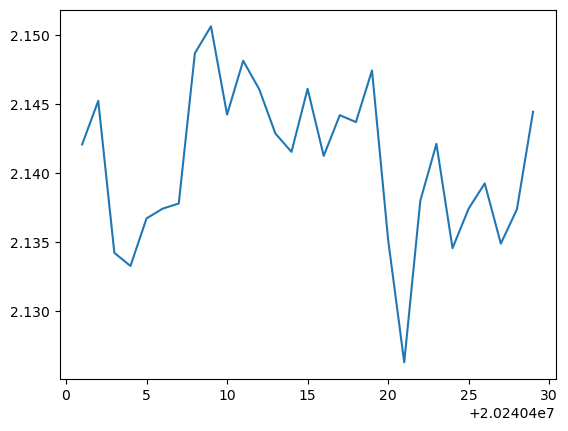

In [293]:
plt.plot(day_list, final_df_2['pressure_2'].mean())

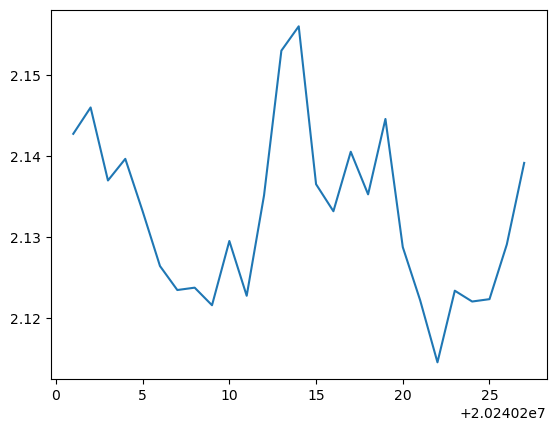

In [294]:
plt.plot(day_list_2, final_df_3['pressure_2'].mean())

In [266]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

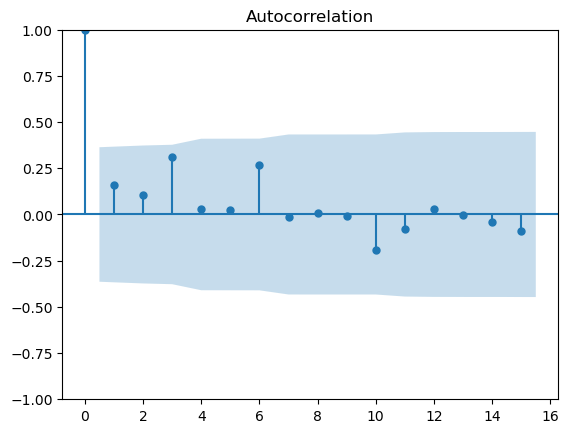

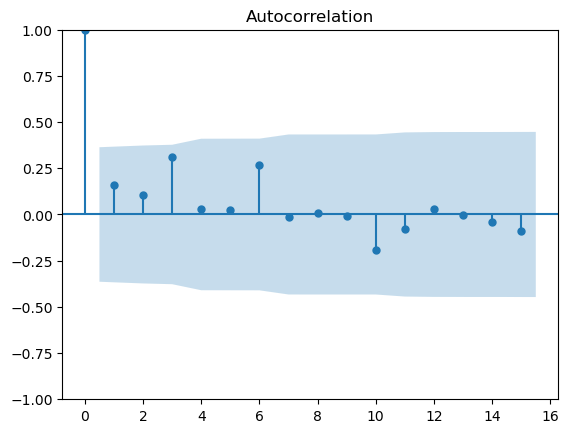

In [280]:
plot_acf(final_df_2['pressure_1'].max())

# Autocorrelation plot

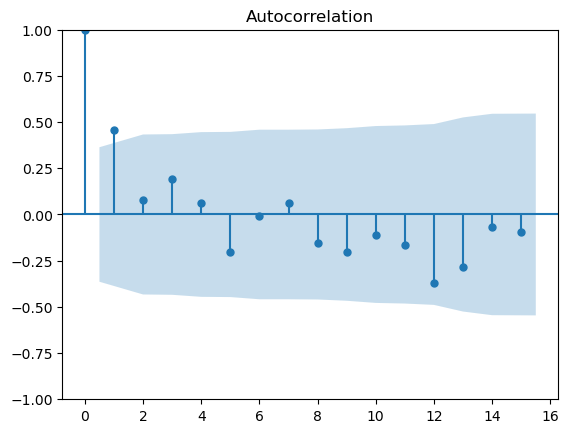

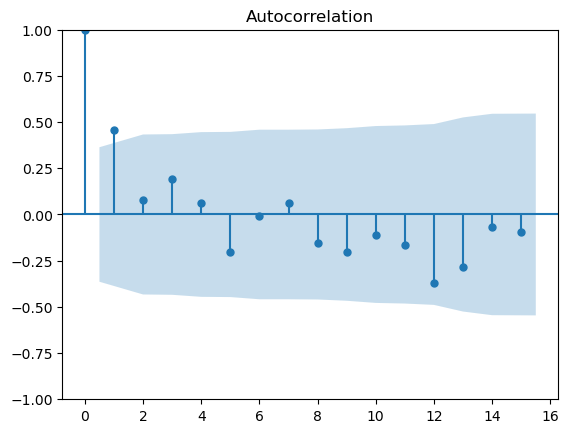

In [278]:
plot_acf(final_df_2['pressure_2'].mean())

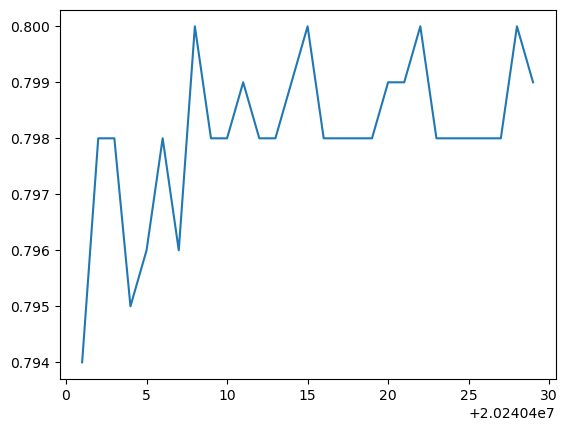

In [281]:
# measure of misalignment
#1. identifying outliers (anomaly detection?)
plt.plot(day_list, final_df_2['pressure_1'].max())


# Linear Regression using our new dataframe

In [185]:
model_new = LinearRegression()

In [228]:
processed_dataframe_list = []
day_to_query = [20240603,20240604,20240605,20240606,20240607,20240608,20240609]
# df = query(20240603,1)
# df.columns
for day in day_to_query:
    df = query(day,1)
    new_df = process_dataframe(df,'max')
    processed_dataframe_list.append(new_df)
del df
del new_df
final_df = pd.concat(processed_dataframe_list, axis = 1)

# final_df.T.shape

# final_df['Hour']

In [230]:
# takes the columns and turns them into numpy arrays
electricity_1_array = np.array(final_df_2['pressure_1']).reshape(-1,1)
maintenance_array_new = np.array(final_df_2['is_maintenance']).reshape(-1,1)

In [231]:
# splits the arrays into train and test sets
electricity_train, electricity_test, maintenance_train, maintenance_test = train_test_split(electricity_1_array, maintenance_array_new,random_state=104, test_size=0.25, shuffle=True)

In [232]:
# trains the model
model_electricity_pressure.fit(electricity_train, maintenance_train)

LinearRegression()

In [233]:
# uses the model to predict pressure_1
y_pred_maintenance = model_electricity_pressure.predict(electricity_test)

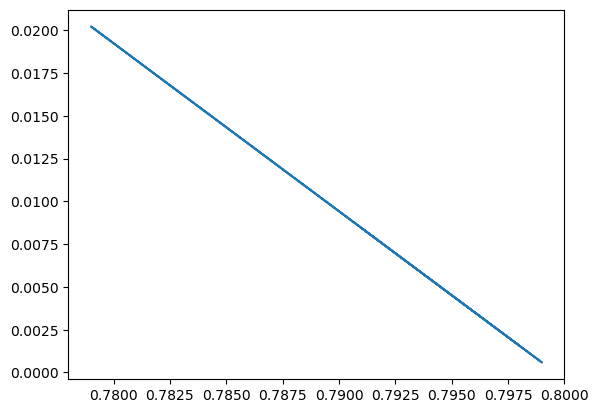

In [234]:
plt.plot(electricity_test, y_pred_maintenance)

# concatenated the dataframes

In [ ]:
processed_dataframe_list = []
day_to_query = [20240603,20240604,20240605,20240606,20240607,20240608,20240609]
# df = query(20240603,1)
# df.columns
for day in day_to_query:
    df = query(day,1)
    new_df = process_dataframe(df,'max')
    processed_dataframe_list.append(new_df)
del df
del new_df
final_df = pd.concat(processed_dataframe_list, axis = 1)

# final_df.T.shape

# final_df['Hour']

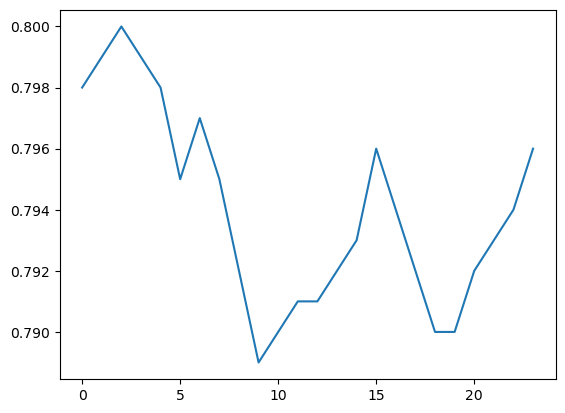

In [ ]:
df_1 = query(20240603,1)
df_2 = query(20240606,1)

df_1 = process_dataframe(df_1,'max')
df_2 = process_dataframe(df_2,'max')

# plt.plot(df_1['electricity_1'])
plt.plot(df_2['pressure_1'])

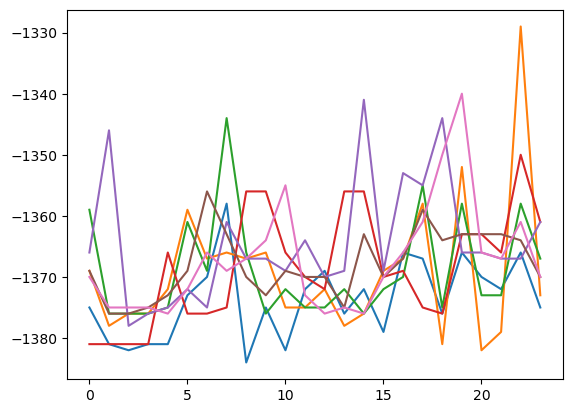

In [ ]:
plt.plot(final_df['electricity_1'])

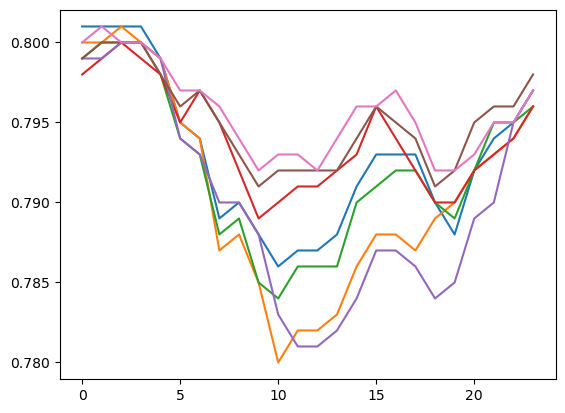

In [ ]:
plt.plot(final_df['pressure_1'])

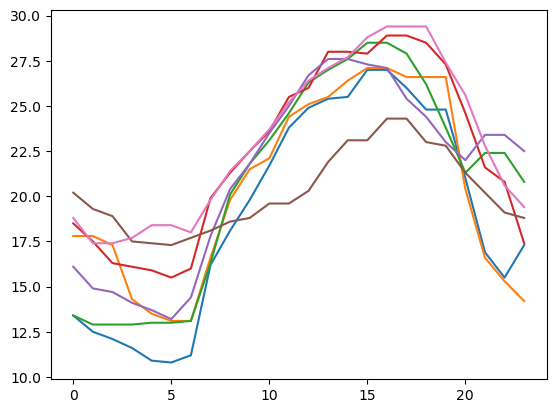

In [ ]:
plt.plot(final_df['outside_temperature'])

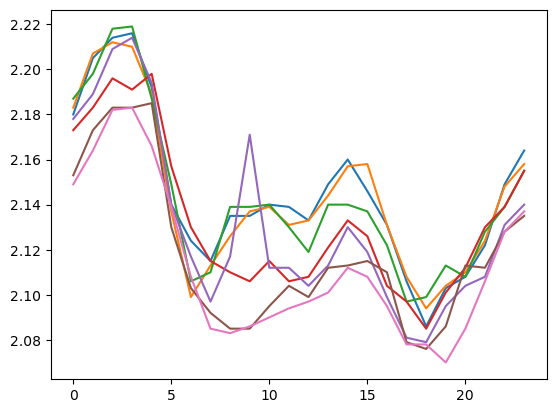

In [119]:
plt.plot(final_df['pressure_2'])

In [125]:
final_df['electricity_1']

,electricity_1,electricity_1,electricity_1,electricity_1,electricity_1,electricity_1,electricity_1
0,-1375.0,-1369.0,-1359.0,-1381.0,-1366.0,-1369.0,-1370.0
1,-1381.0,-1378.0,-1376.0,-1381.0,-1346.0,-1376.0,-1375.0
2,-1382.0,-1376.0,-1376.0,-1381.0,-1378.0,-1376.0,-1375.0
3,-1381.0,-1376.0,-1376.0,-1381.0,-1376.0,-1375.0,-1375.0
4,-1381.0,-1372.0,-1375.0,-1366.0,-1375.0,-1373.0,-1376.0
5,-1373.0,-1359.0,-1361.0,-1376.0,-1372.0,-1369.0,-1372.0
6,-1370.0,-1367.0,-1369.0,-1376.0,-1375.0,-1356.0,-1366.0
7,-1358.0,-1366.0,-1344.0,-1375.0,-1361.0,-1363.0,-1369.0
8,-1384.0,-1367.0,-1366.0,-1356.0,-1367.0,-1370.0,-1367.0
9,-1375.0,-1366.0,-1376.0,-1356.0,-1367.0,-1373.0,-1364.0


In [126]:
model_adjusted = LinearRegression()

In [128]:
electricity_new_array = np.array(final_df['electricity_1'])
outside_new_array = np.array(final_df['outside_temperature'])

In [129]:
electricity_new_train, electricity_new_test, outside_new_train, outside_new_test = train_test_split(electricity_new_array,outside_new_array,random_state = 42)

In [131]:
model_adjusted.fit(outside_new_train,electricity_new_train)

LinearRegression()

In [132]:
predicted_electricity = model_adjusted.predict(outside_new_test)

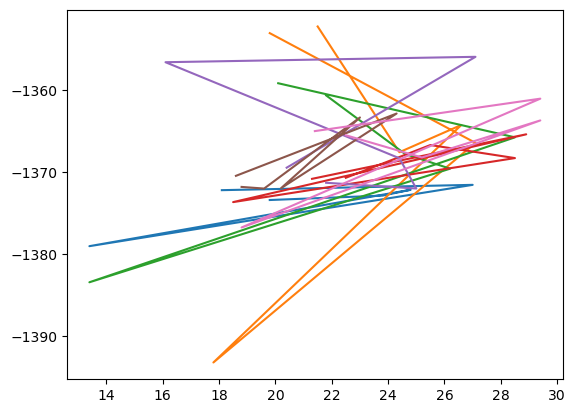

In [133]:
plt.plot(outside_new_test, predicted_electricity)

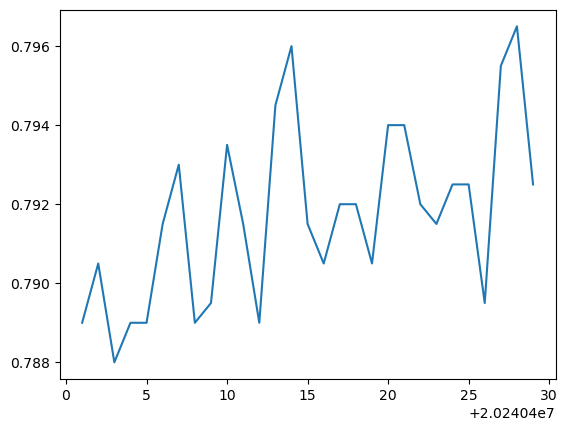

In [247]:
plt.plot(day_list,final_df_2['pressure_1'].median())

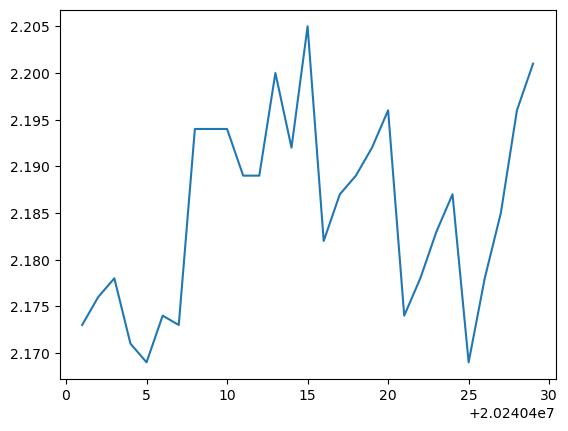

In [254]:
plt.plot(day_list, final_df_2['pressure_2'].max())

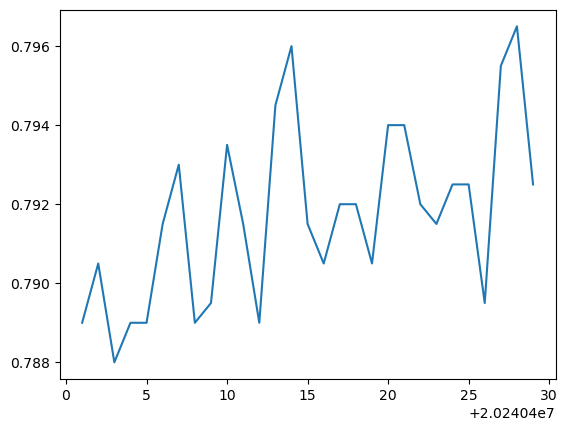

In [256]:
plt.plot(day_list, final_df_2['pressure_1'].median())

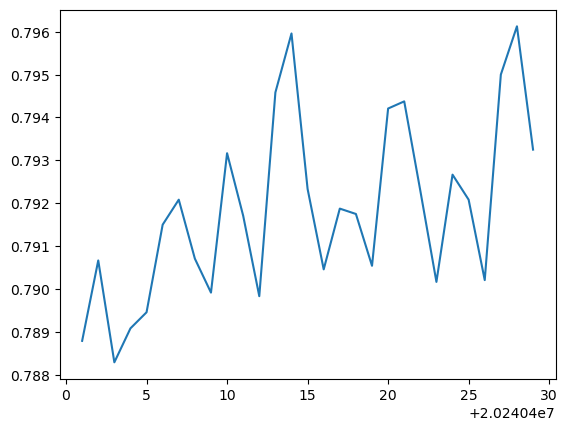

In [258]:
plt.plot(day_list, final_df_2['pressure_1'].mean())

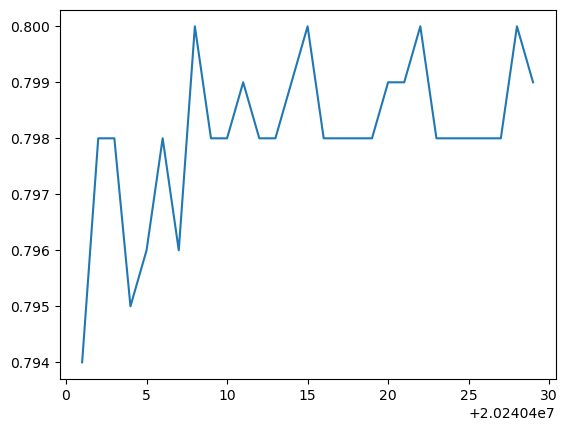

In [259]:
plt.plot(day_list, final_df_2['pressure_1'].max())

In [ ]:
def plot_kmeans_results():
    rotation_angle = 45
    date_form = mdates.DateFormatter('%Y-%m-%d')
    for key in keys:
        ax = plt.gca()
        ax.xaxis.set_major_formatter(date_form)
        plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right")
        # RMS 시계열
        plt.plot(filtered_df_dict[key]['LogTime'], rms_dict[key], label='AccRms')
        # 그래프 제목과 레이블 설정
        plt.title(f'K-means Labels and RMS Values for key {key}, operating: {len(indices)},  non-operating: {len(labels_kmeans[start_index:end_index]) - len(indices)}', fontsize=16)
        plt.xlabel('Log Time', fontsize=14)
        plt.ylabel('Value', fontsize=14)
        # 범례 추가
        plt.legend()
        # 그리드 추가
        plt.grid(True)
        # 그래프 표시
        plt.show()

plt.plot()